---
# Sustained Radiation Events (SREs) - Global Analysis 
---
This notebook provides an overview of high vs. low SREs asymmetry on a global scale as well as other relevant maps. 

The data used in this notebook are from CMIP6 Climate models.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

In [10]:
import my_functions
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
from cmip6_basic_tools.functions_raw_data import RawData, cbt
import numpy as np
import pickle
import matplotlib
import matplotlib.colors as colors
import xesmf as xe
import warnings
from shapely.errors import ShapelyDeprecationWarning

matplotlib.rcParams.update({'font.size': 20})
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

--- 
## Loading Data

The 'meshs' dictionnary provides the mesh (calculated using the get_mesh(model_name) function from my_functions.py) for all models considered.

The 'maps' dictionnary provides the map (calculated using the Get_SREs_maps.py script) of the number of SREs for different lengths and percentiles for all model considered. The map values can be accessed using the following structure (see Get_SREs_maps.py):

```python
maps[model_name][i, lat_index, lon_index, L]
```
where:
- 'i' is an indicator: 0 signifies SREs below the 5th percentile, while 1 indicates those above the 95th percentile
- 'L' represents the length of the considered SREs


In [3]:
meshs = pickle.load(open(f'Data/meshs.pickle', 'rb')) # Load dictionnary with meshs created using the function get_mesh.py
maps  = pickle.load(open(f'Data/maps.pickle', 'rb'))  # Load dictionnary with maps created using the script Get_SREs_maps.py

---
## Maps Visualisation

The following cells show maps for all models as well as the multi-model median on a common mesh.

This first one compute the absolute difference in decadal occurence (L = 4) between high SREs (>95th percentile) and low SREs (<5th percentile).

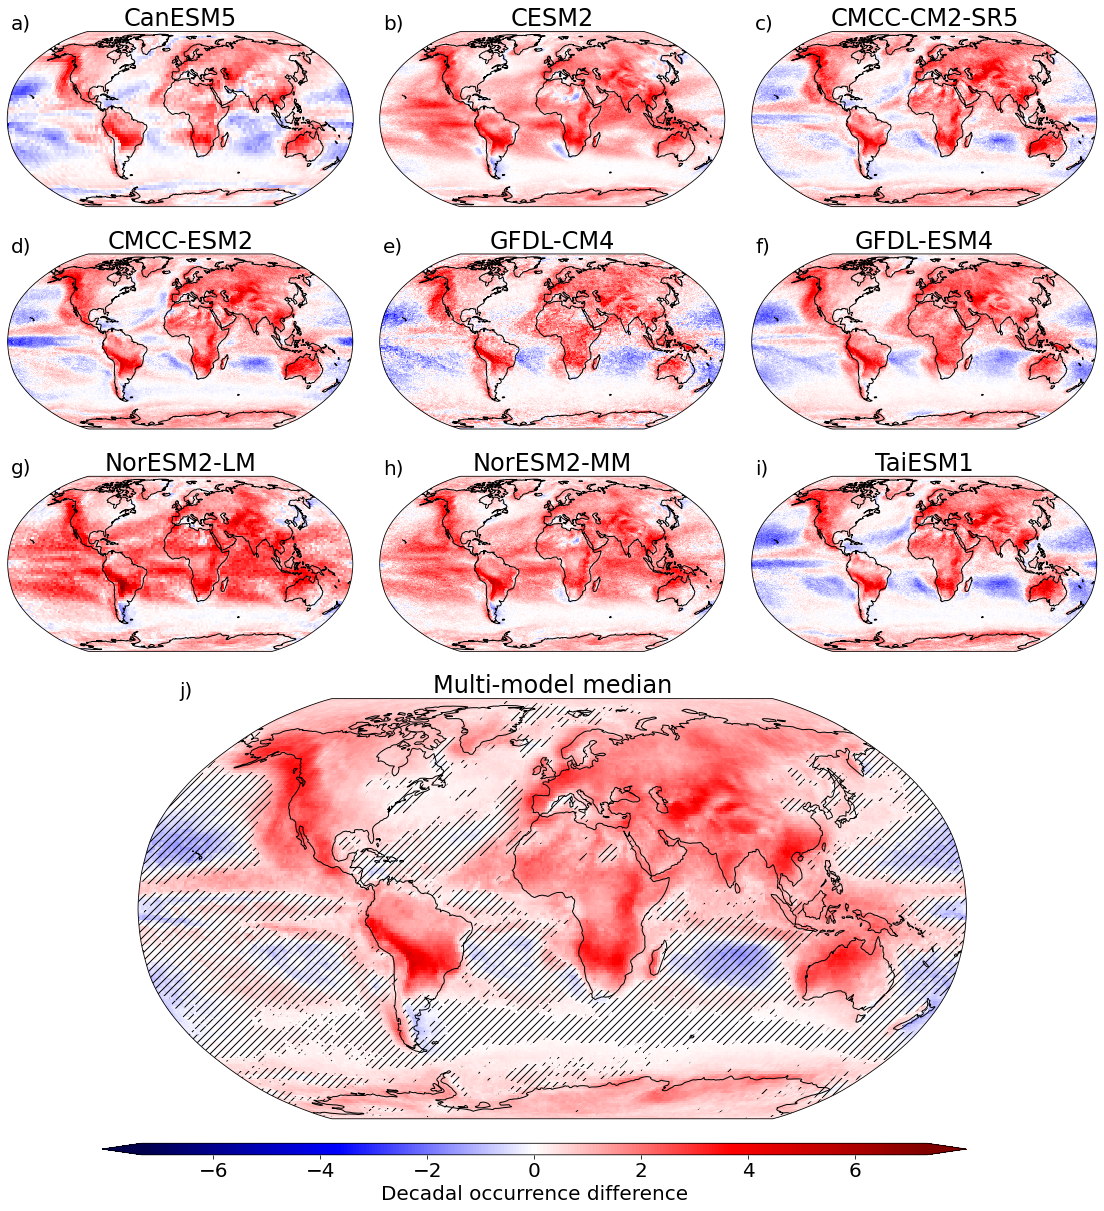

In [12]:
# Create a common mesh for the multi-model maps
lons_out = np.linspace(0, 360, 361 * 1)
lats_out = np.linspace(-90, 90, 181 * 1)
grid_out = {'lon': lons_out, 'lat': lats_out}  # 1 deg
count = 0
len_lat = len(grid_out['lat'])
len_lon = len(grid_out['lon'])

all_models_data = np.zeros(shape=(0, len_lat, len_lon))

# Used for common bounds for the colorbar
data_min =  np.inf
data_max = -np.inf
plots = []


fig = plt.figure(figsize = (20,20))

gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 2.4], wspace = 0)

# Plot the maps for all models
for m, model_name in enumerate(maps):

    mesh = meshs[model_name]
    map  = maps[model_name]

    # To know the length of the time series
    rsds_Zurich_model = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))[model_name]
    n_years           = len(rsds_Zurich_model)//365

    to_plot = (map[1,:,:,4]-map[0,:,:,4])/n_years*10

    if m < 3:
        ax = fig.add_subplot(gs[0,m], projection=ccrs.Robinson())
    else:
        if m < 6:
            ax = fig.add_subplot(gs[1,m-3], projection=ccrs.Robinson())
        else:
            ax = fig.add_subplot(gs[2,m-6], projection=ccrs.Robinson())

    ax.coastlines()
    ax.set_title(model_name)
    plot = ax.pcolormesh(mesh['lon'], mesh['lat'], to_plot, norm=colors.CenteredNorm(), transform=ccrs.PlateCarree(), cmap='seismic')

    
    # Add the panel letter on the figure
    ax.text(0.01, 1.1,  chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')

    # For the common colorbar limits afterwards
    plots.append(plot)

    # For the multi-model maps afterwards
    lats_in, lons_in = mesh['lat'], mesh['lon']
    grid_in = {'lon': lons_in, 'lat': lats_in}
    regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    data_regridded = regridder(to_plot)
    all_models_data = np.append(all_models_data, [data_regridded], axis=0)


# Compute the multi-model map
multimodel_median = np.nanmedian(all_models_data, axis=0)

# How many models show an opposite sign trend? Used for hatching.
N_models = all_models_data.shape[0]
direction_from_multimodel = np.sign(multimodel_median)
sign_all = np.sign(all_models_data)
dir_3d = np.array([direction_from_multimodel] * N_models)
df = sign_all != dir_3d
count_diff = np.count_nonzero(df, axis=0)  # the number of models that disagree with the multimodel median; you can hatch where count_diff > 2 for example or have a few levels of hatching
        
# Plot the multi-model map
ax = fig.add_subplot(gs[3,:], projection=ccrs.Robinson())
ax.set_title('Multi-model median')
ax.coastlines()
plot = ax.pcolormesh(lons_out, lats_out, multimodel_median, norm=colors.CenteredNorm(), transform=ccrs.PlateCarree(), cmap='seismic')
ax.contourf(lons_out, lats_out, count_diff > 1, transform=ccrs.PlateCarree(), colors='none',levels=[.5, 1.5], hatches=[3*'/',3*'/'])
ax.text(0.05, 1.04, 'j)', transform=ax.transAxes, va='top')
plots.append(plot)

# Set the same colorbar limits for all the plots
vmin = min(plot.get_array().min() for plot in plots)
vmax = max(plot.get_array().max() for plot in plots)

# Set the norm for all the plots
norm = colors.Normalize(vmin=-max(abs(vmin), abs(vmax)), vmax=max(abs(vmin), abs(vmax)))
for plot in plots:
    plot.set_norm(norm)

# Add the colorbar to the entire figure
cax = fig.add_axes([0.2, 0.1, 0.6, 0.008]) # [left, bottom, width, height]
cb = fig.colorbar(plots[0], cax=cax, orientation="horizontal", extend='both')
cb.ax.set_xlabel('Decadal occurrence difference')

plt.savefig(f'Figures/SREs_Analysis/maps.png', bbox_inches='tight')

plt.show()

The following cell simply shows the decadal occurence (L=4) of low SREs (<5th percentile).

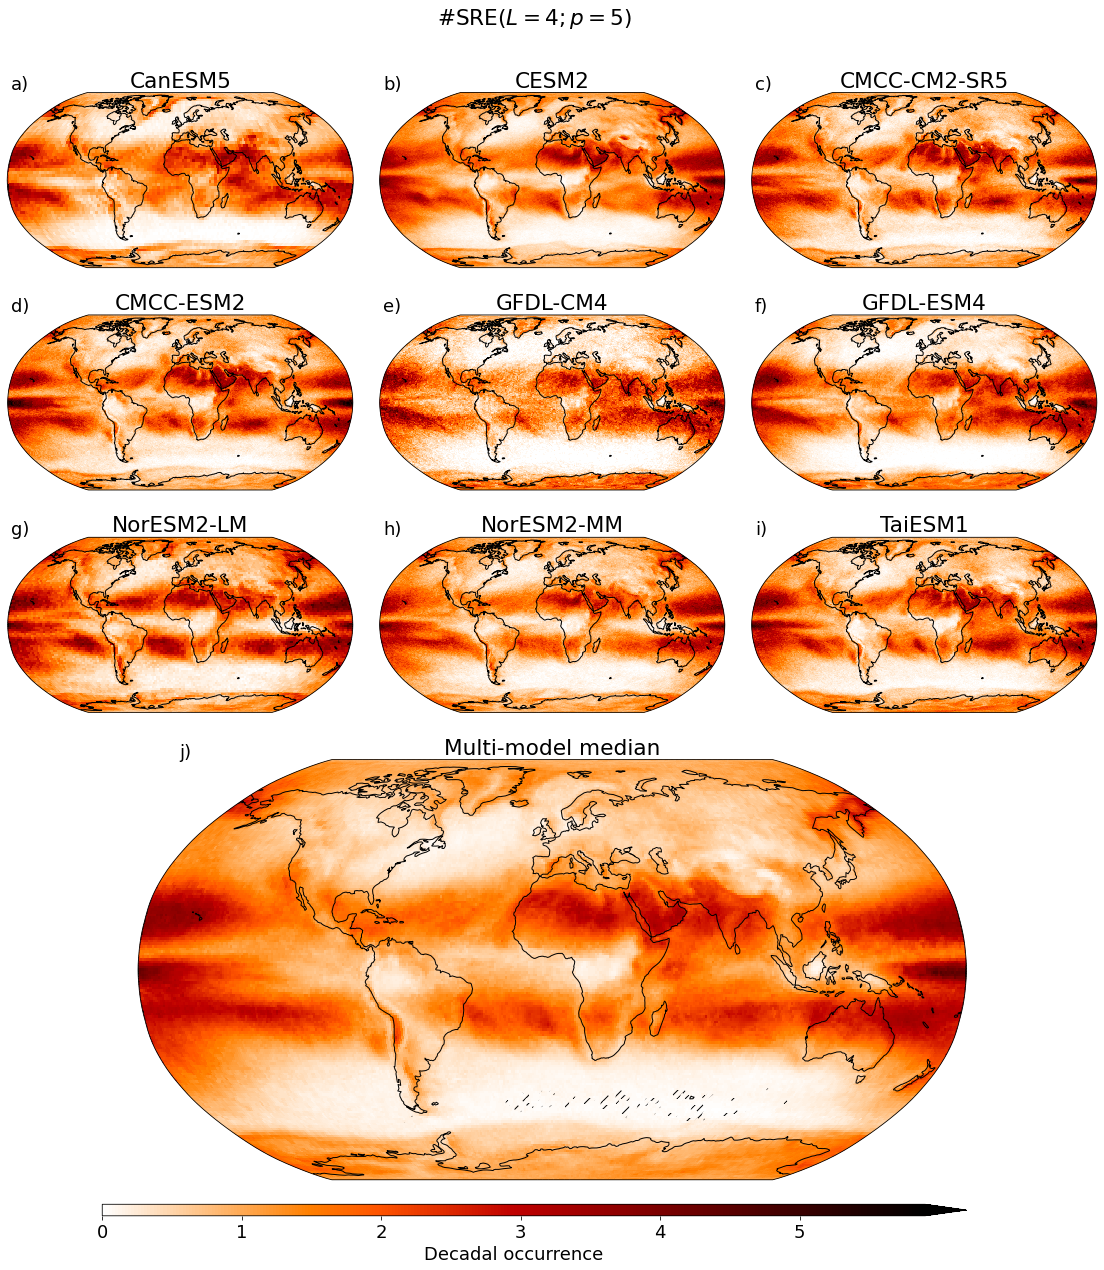

In [23]:
# Create a common mesh for the multi-model maps
lons_out = np.linspace(0, 360, 361 * 1)
lats_out = np.linspace(-90, 90, 181 * 1)
grid_out = {'lon': lons_out, 'lat': lats_out}  # 1 deg
count = 0
len_lat = len(grid_out['lat'])
len_lon = len(grid_out['lon'])

all_models_data = np.zeros(shape=(0, len_lat, len_lon))

# Used for common bounds for the colorbar
data_min =  np.inf
data_max = -np.inf
plots = []


fig = plt.figure(figsize = (20,20))

fig.suptitle('$\#\mathrm{ SRE}(L = 4;p = 5)$').set_y(0.94)

gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 2.4], wspace = 0)

# Plot the maps for all models
for m, model_name in enumerate(maps):

    mesh = meshs[model_name]
    map  = maps[model_name]

    # To know the length of the time series
    rsds_Zurich_model = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))[model_name]
    n_years           = len(rsds_Zurich_model)//365

    to_plot = map[0,:,:,4]/n_years*10

    if m < 3:
        ax = fig.add_subplot(gs[0,m], projection=ccrs.Robinson())
    else:
        if m < 6:
            ax = fig.add_subplot(gs[1,m-3], projection=ccrs.Robinson())
        else:
            ax = fig.add_subplot(gs[2,m-6], projection=ccrs.Robinson())

    ax.coastlines()
    ax.set_title(model_name)
    plot = ax.pcolormesh(mesh['lon'], mesh['lat'], to_plot, transform=ccrs.PlateCarree(), cmap='gist_heat_r')

    
    # Add the panel letter on the figure
    ax.text(0.01, 1.1,  chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')

    # For the common colorbar limits afterwards
    plots.append(plot)

    # For the multi-model maps afterwards
    lats_in, lons_in = mesh['lat'], mesh['lon']
    grid_in = {'lon': lons_in, 'lat': lats_in}
    regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    data_regridded = regridder(to_plot)
    all_models_data = np.append(all_models_data, [data_regridded], axis=0)


# Compute the multi-model map
multimodel_median = np.nanmedian(all_models_data, axis=0)

# How many models show an opposite sign trend? Used for hatching.
N_models = all_models_data.shape[0]
direction_from_multimodel = np.sign(multimodel_median)
sign_all = np.sign(all_models_data)
dir_3d = np.array([direction_from_multimodel] * N_models)
df = sign_all != dir_3d
count_diff = np.count_nonzero(df, axis=0)  # the number of models that disagree with the multimodel median; you can hatch where count_diff > 2 for example or have a few levels of hatching
        
# Plot the multi-model map
ax = fig.add_subplot(gs[3,:], projection=ccrs.Robinson())
ax.set_title('Multi-model median')
ax.coastlines()
plot = ax.pcolormesh(lons_out, lats_out, multimodel_median, transform=ccrs.PlateCarree(), cmap='gist_heat_r')
ax.contourf(lons_out, lats_out, count_diff > 1, transform=ccrs.PlateCarree(), colors='none',levels=[.5, 1.5], hatches=[3*'/',3*'/'])
ax.text(0.05, 1.04, 'j)', transform=ax.transAxes, va='top')
plots.append(plot)

# Set the same colorbar limits for all the plots
vmin = min(plot.get_array().min() for plot in plots)
vmax = max(plot.get_array().max() for plot in plots)

# Set the norm for all the plots
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for plot in plots:
    plot.set_norm(norm)

# Add the colorbar to the entire figure
cax = fig.add_axes([0.2, 0.1, 0.6, 0.008]) # [left, bottom, width, height]
cb = fig.colorbar(plots[0], cax=cax, orientation="horizontal", extend='max')
cb.ax.set_xlabel('Decadal occurrence')

plt.savefig(f'Figures/SREs_Analysis/maps_5th.png', bbox_inches='tight')

plt.show()

The following cell simply shows the decadal occurence (L=4) of high SREs (>95th percentile).

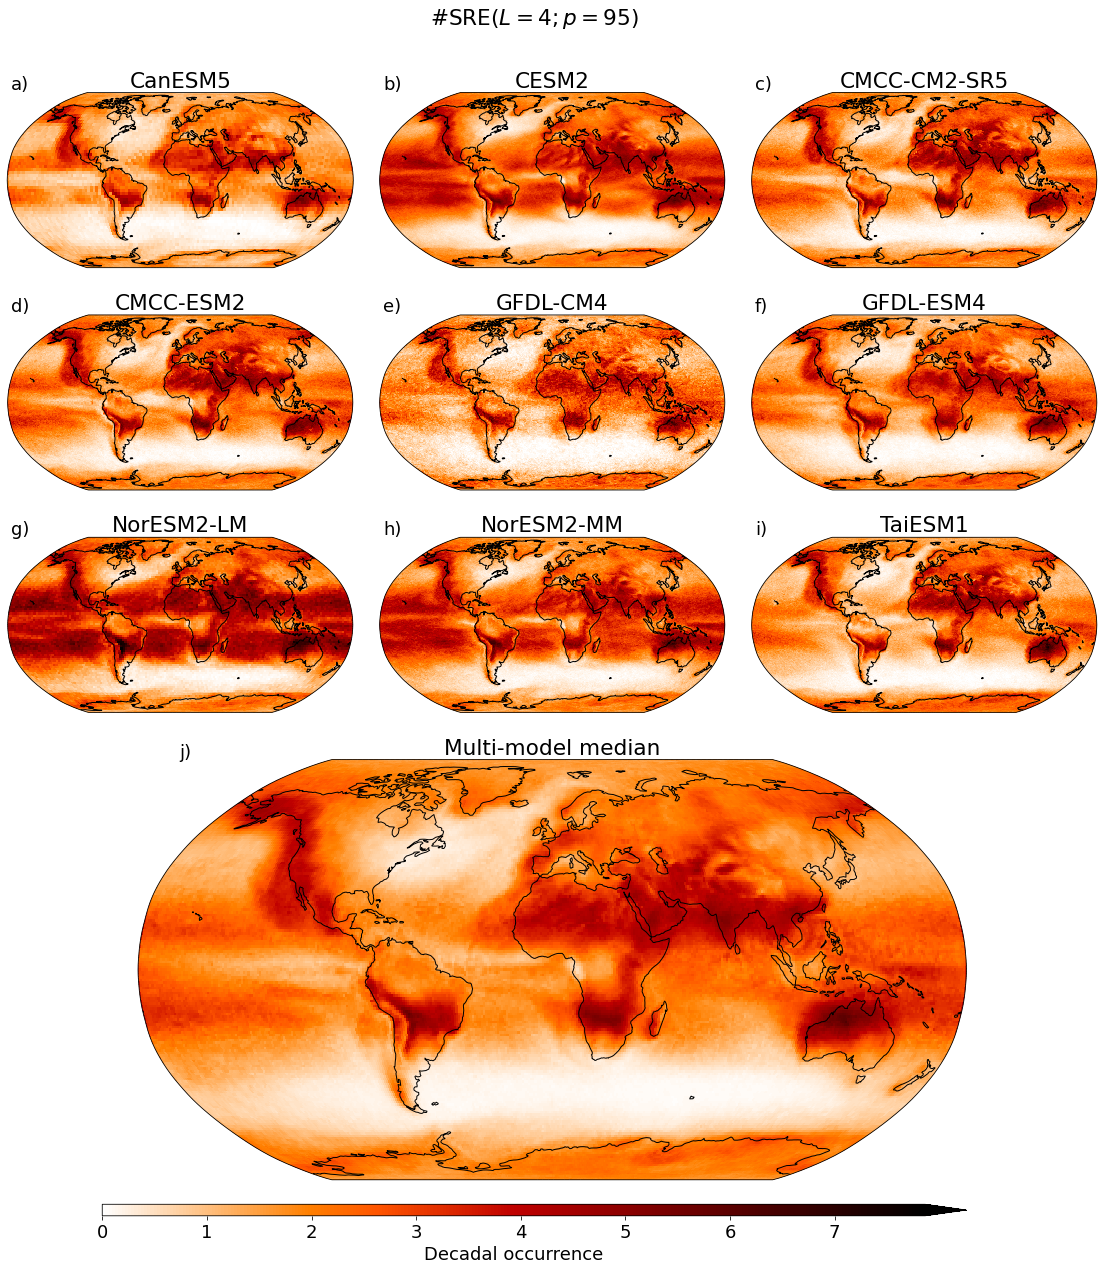

In [24]:
# Create a common mesh for the multi-model maps
lons_out = np.linspace(0, 360, 361 * 1)
lats_out = np.linspace(-90, 90, 181 * 1)
grid_out = {'lon': lons_out, 'lat': lats_out}  # 1 deg
count = 0
len_lat = len(grid_out['lat'])
len_lon = len(grid_out['lon'])

all_models_data = np.zeros(shape=(0, len_lat, len_lon))

# Used for common bounds for the colorbar
data_min =  np.inf
data_max = -np.inf
plots = []


fig = plt.figure(figsize = (20,20))

fig.suptitle('$\#\mathrm{ SRE}(L = 4;p = 95)$').set_y(0.94)

gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 2.4], wspace = 0)

# Plot the maps for all models
for m, model_name in enumerate(maps):

    mesh = meshs[model_name]
    map  = maps[model_name]

    # To know the length of the time series
    rsds_Zurich_model = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))[model_name]
    n_years           = len(rsds_Zurich_model)//365

    to_plot = map[1,:,:,4]/n_years*10

    if m < 3:
        ax = fig.add_subplot(gs[0,m], projection=ccrs.Robinson())
    else:
        if m < 6:
            ax = fig.add_subplot(gs[1,m-3], projection=ccrs.Robinson())
        else:
            ax = fig.add_subplot(gs[2,m-6], projection=ccrs.Robinson())

    ax.coastlines()
    ax.set_title(model_name)
    plot = ax.pcolormesh(mesh['lon'], mesh['lat'], to_plot, transform=ccrs.PlateCarree(), cmap='gist_heat_r')

    
    # Add the panel letter on the figure
    ax.text(0.01, 1.1,  chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')

    # For the common colorbar limits afterwards
    plots.append(plot)

    # For the multi-model maps afterwards
    lats_in, lons_in = mesh['lat'], mesh['lon']
    grid_in = {'lon': lons_in, 'lat': lats_in}
    regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    data_regridded = regridder(to_plot)
    all_models_data = np.append(all_models_data, [data_regridded], axis=0)


# Compute the multi-model map
multimodel_median = np.nanmedian(all_models_data, axis=0)

# How many models show an opposite sign trend? Used for hatching.
N_models = all_models_data.shape[0]
direction_from_multimodel = np.sign(multimodel_median)
sign_all = np.sign(all_models_data)
dir_3d = np.array([direction_from_multimodel] * N_models)
df = sign_all != dir_3d
count_diff = np.count_nonzero(df, axis=0)  # the number of models that disagree with the multimodel median; you can hatch where count_diff > 2 for example or have a few levels of hatching
        
# Plot the multi-model map
ax = fig.add_subplot(gs[3,:], projection=ccrs.Robinson())
ax.set_title('Multi-model median')
ax.coastlines()
plot = ax.pcolormesh(lons_out, lats_out, multimodel_median, transform=ccrs.PlateCarree(), cmap='gist_heat_r')
ax.contourf(lons_out, lats_out, count_diff > 1, transform=ccrs.PlateCarree(), colors='none',levels=[.5, 1.5], hatches=[3*'/',3*'/'])
ax.text(0.05, 1.04, 'j)', transform=ax.transAxes, va='top')
plots.append(plot)

# Set the same colorbar limits for all the plots
vmin = min(plot.get_array().min() for plot in plots)
vmax = max(plot.get_array().max() for plot in plots)

# Set the norm for all the plots
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for plot in plots:
    plot.set_norm(norm)

# Add the colorbar to the entire figure
cax = fig.add_axes([0.2, 0.1, 0.6, 0.008]) # [left, bottom, width, height]
cb = fig.colorbar(plots[0], cax=cax, orientation="horizontal", extend='max')
cb.ax.set_xlabel('Decadal occurrence')

plt.savefig(f'Figures/SREs_Analysis/maps_95th.png', bbox_inches='tight')

plt.show()

/tmp/ipykernel_42837/3770368064.py:33: RuntimeWarning: divide by zero encountered in log10
  to_plot = np.log10(map[0,:,:,4]/map[0,:,:,3])
/tmp/ipykernel_42837/3770368064.py:33: RuntimeWarning: divide by zero encountered in true_divide
  to_plot = np.log10(map[0,:,:,4]/map[0,:,:,3])
/tmp/ipykernel_42837/3770368064.py:33: RuntimeWarning: invalid value encountered in true_divide
  to_plot = np.log10(map[0,:,:,4]/map[0,:,:,3])


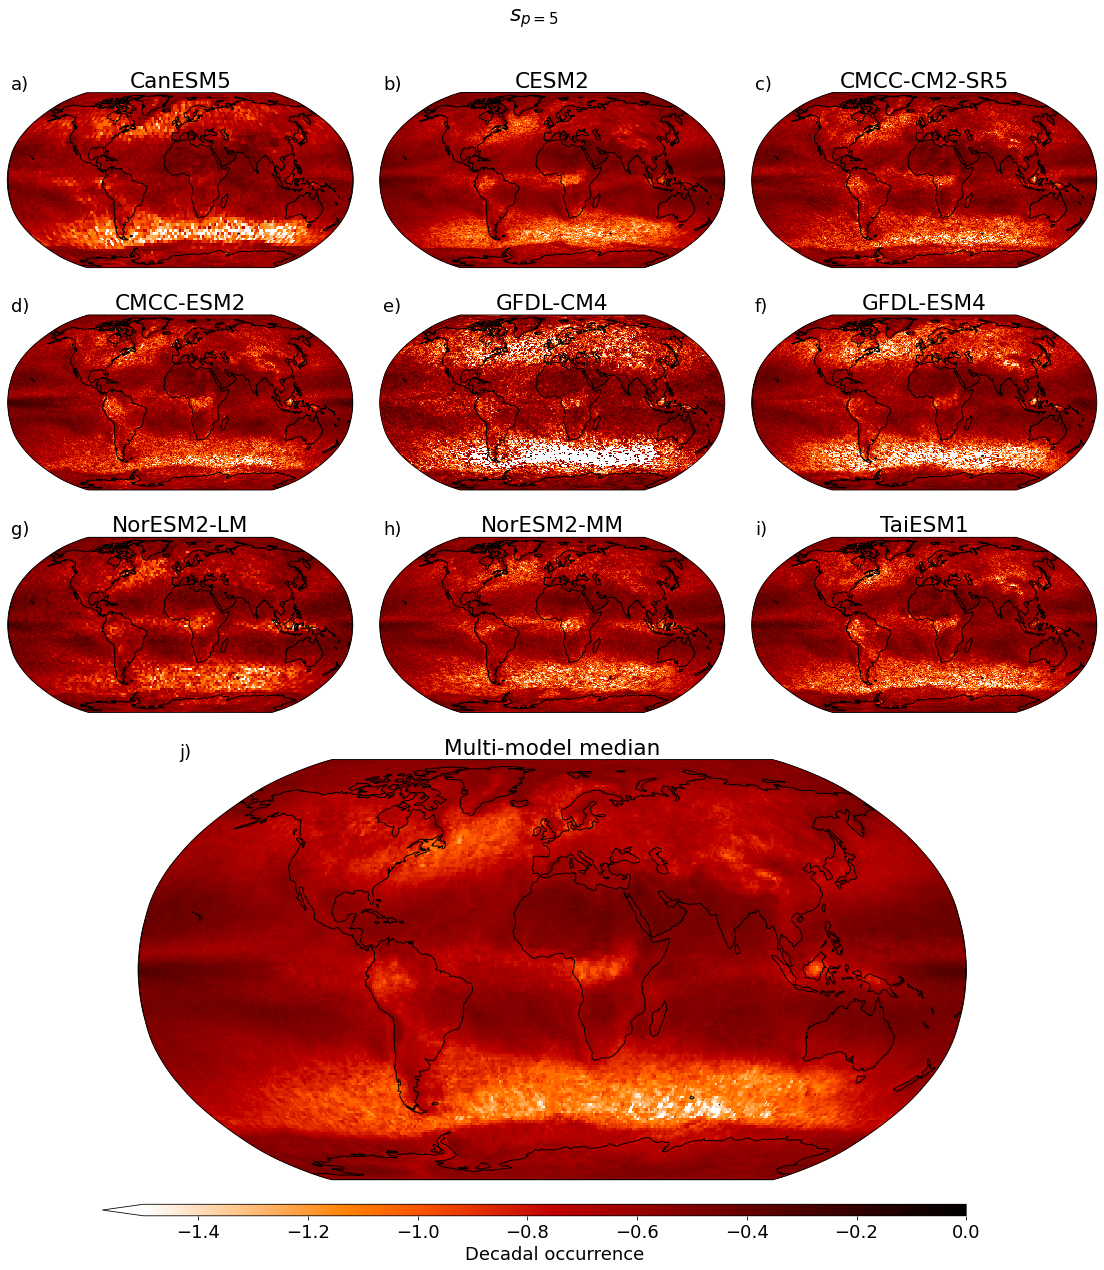

In [5]:
# Create a common mesh for the multi-model maps
lons_out = np.linspace(0, 360, 361 * 1)
lats_out = np.linspace(-90, 90, 181 * 1)
grid_out = {'lon': lons_out, 'lat': lats_out}  # 1 deg
count = 0
len_lat = len(grid_out['lat'])
len_lon = len(grid_out['lon'])

all_models_data = np.zeros(shape=(0, len_lat, len_lon))

# Used for common bounds for the colorbar
data_min =  np.inf
data_max = -np.inf
plots = []


fig = plt.figure(figsize = (20,20))

fig.suptitle('$s_{p=5}$').set_y(0.94)

gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 2.4], wspace = 0)

# Plot the maps for all models
for m, model_name in enumerate(maps):

    mesh = meshs[model_name]
    map  = maps[model_name]

    # To know the length of the time series
    rsds_Zurich_model = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))[model_name]
    n_years           = len(rsds_Zurich_model)//365

    to_plot = np.log10(map[0,:,:,4]/map[0,:,:,3])

    if m < 3:
        ax = fig.add_subplot(gs[0,m], projection=ccrs.Robinson())
    else:
        if m < 6:
            ax = fig.add_subplot(gs[1,m-3], projection=ccrs.Robinson())
        else:
            ax = fig.add_subplot(gs[2,m-6], projection=ccrs.Robinson())

    ax.coastlines()
    ax.set_title(model_name)
    plot = ax.pcolormesh(mesh['lon'], mesh['lat'], to_plot, transform=ccrs.PlateCarree(), cmap='gist_heat_r')

    
    # Add the panel letter on the figure
    ax.text(0.01, 1.1,  chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')

    # For the common colorbar limits afterwards
    plots.append(plot)

    # For the multi-model maps afterwards
    lats_in, lons_in = mesh['lat'], mesh['lon']
    grid_in = {'lon': lons_in, 'lat': lats_in}
    regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    data_regridded = regridder(to_plot)
    all_models_data = np.append(all_models_data, [data_regridded], axis=0)


# Compute the multi-model map
multimodel_median = np.nanmedian(all_models_data, axis=0)

# How many models show an opposite sign trend? Used for hatching.
N_models = all_models_data.shape[0]
direction_from_multimodel = np.sign(multimodel_median)
sign_all = np.sign(all_models_data)
dir_3d = np.array([direction_from_multimodel] * N_models)
df = sign_all != dir_3d
count_diff = np.count_nonzero(df, axis=0)  # the number of models that disagree with the multimodel median; you can hatch where count_diff > 2 for example or have a few levels of hatching
        
# Plot the multi-model map
ax = fig.add_subplot(gs[3,:], projection=ccrs.Robinson())
ax.set_title('Multi-model median')
ax.coastlines()
plot = ax.pcolormesh(lons_out, lats_out, multimodel_median, transform=ccrs.PlateCarree(), cmap='gist_heat_r')
ax.contourf(lons_out, lats_out, count_diff > 1, transform=ccrs.PlateCarree(), colors='none',levels=[.5, 1.5], hatches=[3*'/',3*'/'])
ax.text(0.05, 1.04, 'j)', transform=ax.transAxes, va='top')
plots.append(plot)

# Set the same colorbar limits for all the plots
vmin = min(plot.get_array().min() for plot in plots)
vmax = max(plot.get_array().max() for plot in plots)

# Set the norm for all the plots
norm = colors.Normalize(vmin=-1.5, vmax=0)
for plot in plots:
    plot.set_norm(norm)

# Add the colorbar to the entire figure
cax = fig.add_axes([0.2, 0.1, 0.6, 0.008]) # [left, bottom, width, height]
cb = fig.colorbar(plots[0], cax=cax, orientation="horizontal", extend='min')
cb.ax.set_xlabel('Decadal occurrence')

plt.savefig(f'Figures/SREs_Analysis/maps_s_5th.png', bbox_inches='tight')

plt.show()

/tmp/ipykernel_42837/2881342309.py:33: RuntimeWarning: divide by zero encountered in log10
  to_plot = np.log10(map[1,:,:,4]/map[1,:,:,3])


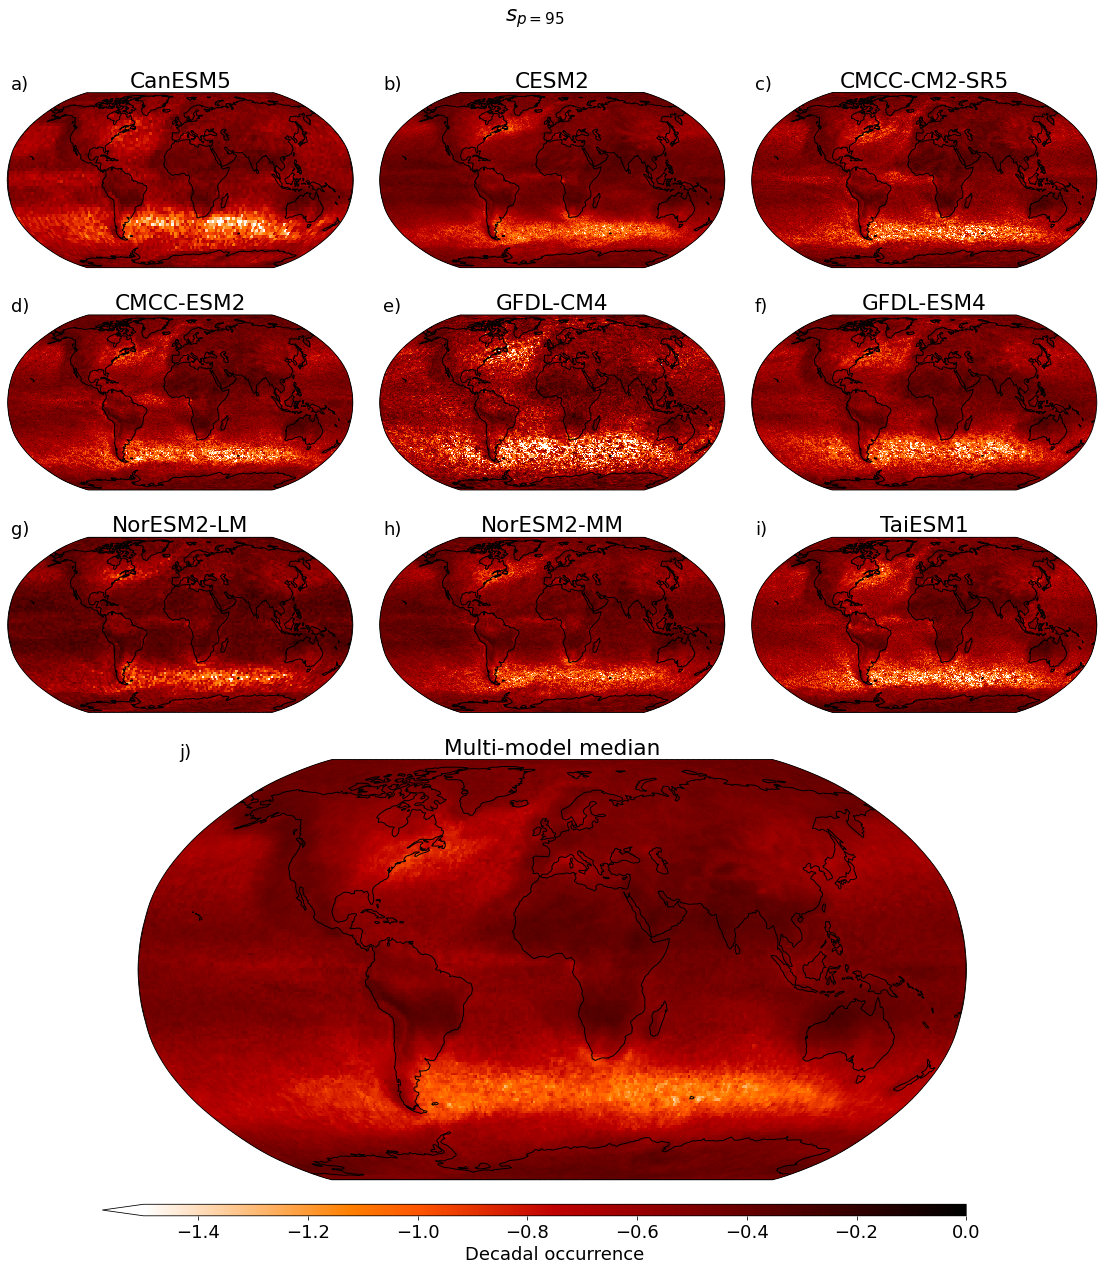

In [6]:
# Create a common mesh for the multi-model maps
lons_out = np.linspace(0, 360, 361 * 1)
lats_out = np.linspace(-90, 90, 181 * 1)
grid_out = {'lon': lons_out, 'lat': lats_out}  # 1 deg
count = 0
len_lat = len(grid_out['lat'])
len_lon = len(grid_out['lon'])

all_models_data = np.zeros(shape=(0, len_lat, len_lon))

# Used for common bounds for the colorbar
data_min =  np.inf
data_max = -np.inf
plots = []


fig = plt.figure(figsize = (20,20))

fig.suptitle('$s_{p=95}$').set_y(0.94)

gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 2.4], wspace = 0)

# Plot the maps for all models
for m, model_name in enumerate(maps):

    mesh = meshs[model_name]
    map  = maps[model_name]

    # To know the length of the time series
    rsds_Zurich_model = pickle.load(open(f'Data/rsds/Zurich.pickle', 'rb'))[model_name]
    n_years           = len(rsds_Zurich_model)//365

    to_plot = np.log10(map[1,:,:,4]/map[1,:,:,3])

    if m < 3:
        ax = fig.add_subplot(gs[0,m], projection=ccrs.Robinson())
    else:
        if m < 6:
            ax = fig.add_subplot(gs[1,m-3], projection=ccrs.Robinson())
        else:
            ax = fig.add_subplot(gs[2,m-6], projection=ccrs.Robinson())

    ax.coastlines()
    ax.set_title(model_name)
    plot = ax.pcolormesh(mesh['lon'], mesh['lat'], to_plot, transform=ccrs.PlateCarree(), cmap='gist_heat_r')

    
    # Add the panel letter on the figure
    ax.text(0.01, 1.1,  chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')

    # For the common colorbar limits afterwards
    plots.append(plot)

    # For the multi-model maps afterwards
    lats_in, lons_in = mesh['lat'], mesh['lon']
    grid_in = {'lon': lons_in, 'lat': lats_in}
    regridder = xe.Regridder(grid_in, grid_out, 'bilinear', periodic=True)
    data_regridded = regridder(to_plot)
    all_models_data = np.append(all_models_data, [data_regridded], axis=0)


# Compute the multi-model map
multimodel_median = np.nanmedian(all_models_data, axis=0)

# How many models show an opposite sign trend? Used for hatching.
N_models = all_models_data.shape[0]
direction_from_multimodel = np.sign(multimodel_median)
sign_all = np.sign(all_models_data)
dir_3d = np.array([direction_from_multimodel] * N_models)
df = sign_all != dir_3d
count_diff = np.count_nonzero(df, axis=0)  # the number of models that disagree with the multimodel median; you can hatch where count_diff > 2 for example or have a few levels of hatching
        
# Plot the multi-model map
ax = fig.add_subplot(gs[3,:], projection=ccrs.Robinson())
ax.set_title('Multi-model median')
ax.coastlines()
plot = ax.pcolormesh(lons_out, lats_out, multimodel_median, transform=ccrs.PlateCarree(), cmap='gist_heat_r')
ax.contourf(lons_out, lats_out, count_diff > 1, transform=ccrs.PlateCarree(), colors='none',levels=[.5, 1.5], hatches=[3*'/',3*'/'])
ax.text(0.05, 1.04, 'j)', transform=ax.transAxes, va='top')
plots.append(plot)

# Set the same colorbar limits for all the plots
vmin = min(plot.get_array().min() for plot in plots)
vmax = max(plot.get_array().max() for plot in plots)

# Set the norm for all the plots
norm = colors.Normalize(vmin=-1.5, vmax=0)
for plot in plots:
    plot.set_norm(norm)

# Add the colorbar to the entire figure
cax = fig.add_axes([0.2, 0.1, 0.6, 0.008]) # [left, bottom, width, height]
cb = fig.colorbar(plots[0], cax=cax, orientation="horizontal", extend='min')
cb.ax.set_xlabel('Decadal occurrence')

plt.savefig(f'Figures/SREs_Analysis/maps_s_95th.png', bbox_inches='tight')

plt.show()